# Reconstruction

Reference: https://tomroelandts.com/articles/astra-toolbox-tutorial-reconstruction-from-projection-images-part-2

In [8]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [9]:
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import imread, imwrite
import matplotlib.pyplot as plt
import astra
import h5py
import os
import mrcfile
from tvtk.api import tvtk
from mayavi import mlab
from IPython.display import Image
import sys
sys.path.append("../..") 
# from cryoem.projections import RotationMatrix

In [10]:
def RotationMatrix(angles):
    vectors = np.zeros((angles.shape[0],12))
    vectors[:,0:3] = [0, 0, 1]

    # center of detector
    vectors[:,3:6] = 0
 
    # vector from detector pixel (0,0) to (0,1)
    vectors[:,6:9] = [1, 0, 0]
     
    # vector from detector pixel (0,0) to (1,0)
    vectors[:,9:12]  = [0, 1, 0]
 
    # create rotation matrix
    c1 = np.cos(angles[:,0]).reshape(-1,1,1)
    c2 = np.cos(angles[:,1]).reshape(-1,1,1)
    c3 = np.cos(angles[:,2]).reshape(-1,1,1)
                        
    s1 = np.sin(angles[:,0]).reshape(-1,1,1)
    s2 = np.sin(angles[:,1]).reshape(-1,1,1)
    s3 = np.sin(angles[:,2]).reshape(-1,1,1)
    vector = vectors[0,:]

    R = np.concatenate([np.concatenate([c1*c2*c3-s1*s3, c1*s3+c2*c3*s1 , -c3*s2],axis=2),\
                        np.concatenate([-c3*s1-c1*c2*s3,    c1*c3-c2*s1*s3 ,   s2*s3],axis=2),\
                        np.concatenate( [c1*s2,             s1*s2          ,   c2],axis=2)],axis=1)
    #R = np.transpose(R, (0, 2, 1))
    
    # rotate previous values
    vectors[:,0:3] = np.matmul(R,vector[0:3])
    vectors[:,6:9] = np.matmul(R,vector[6:9])
    vectors[:,9:12] = np.matmul(R,vector[9:12])

    return vectors

In [11]:
def reconstruct(input_file, output_file, save_mrc=True):
    data = np.load(f'data/{input_file}.npz')
    projections, angles = data["arr_0"].astype(np.float64)[:3000, :, :], data["arr_1"].astype(np.float64)[:3000, :]

    # Generate orientation vectors based on angles
    orientation_vectors   = RotationMatrix(angles)

    # Reshape projections correctly 
    projections1 = np.transpose(projections, (1, 0, 2))
    
    # Get projection dimension
    proj_size = projections1.shape[0]

    # Create projection 2D geometry in ASTRA
    proj_geom = astra.create_proj_geom('parallel3d_vec', proj_size, proj_size, orientation_vectors)
    projections_id = astra.data3d.create('-sino', proj_geom, projections1)

    # Create reconstruction.
    vol_geom = astra.creators.create_vol_geom(proj_size, proj_size, proj_size)
    reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
    alg_cfg = astra.astra_dict('BP3D_CUDA')
    alg_cfg['ProjectionDataId'] = projections_id
    alg_cfg['ReconstructionDataId'] = reconstruction_id
    algorithm_id = astra.algorithm.create(alg_cfg)
    astra.algorithm.run(algorithm_id)
    reconstruction = astra.data3d.get(reconstruction_id)


    # Limit and scale reconstruction.
    reconstruction[reconstruction < 0] = 0
    reconstruction /= np.max(reconstruction)
    reconstruction = np.round(reconstruction * 255).astype(np.uint8)

    # Cleanup.
    astra.algorithm.delete(algorithm_id)
    astra.data3d.delete(reconstruction_id)
    astra.data3d.delete(projections_id)

    # Save reconstruction to mrc file for chimera
    if save_mrc:
        with mrcfile.new(f'data/{output_file}.mrc') as mrc:
            mrc.set_data(reconstruction)
        
    return reconstruction

---

# True Angles and Projections

In [9]:
INPUT_FILE = "5a1a_projections_and_angles"
OUTPUT_FILE = "5a1a_projections_and_angles"

## Create data for reconstruction (projections and angles pairs)

In [5]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# full coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber{NUM_PROJECTIONS}_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')
    
np.savez(f"data/{INPUT_FILE}", data['Projections'], data['Angles'])

## Reconstruction

In [12]:
reconstruction = reconstruct(INPUT_FILE, OUTPUT_FILE, save_mrc=False)

## Plot reconstruction result

In [13]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
#mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

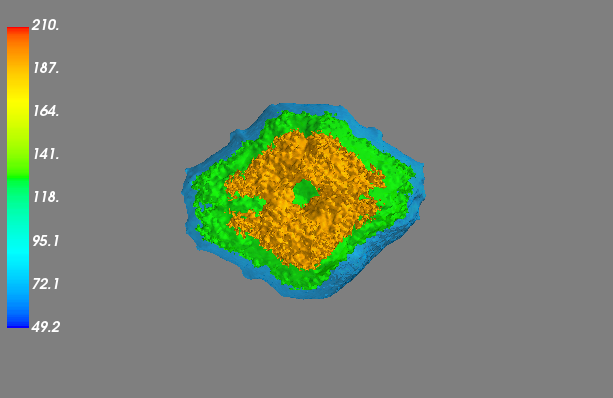

In [3]:
Image(filename='data/5a1a_projections_and_angles.png') 

---

# Half-coverage True Angles and Projections

In [6]:
INPUT_FILE = "5a1a_projections_and_angles_half"
OUTPUT_FILE = "5a1a_projections_and_angles_half"

## Create data for reconstruction (projections and angles pairs)

In [7]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber{NUM_PROJECTIONS}_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')
    
np.savez(f"data/{INPUT_FILE}", data['Projections'], data['Angles'])

## Reconstruction

In [8]:
reconstruction = reconstruct(INPUT_FILE, OUTPUT_FILE)

## Plot reconstruction result

In [9]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
#mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

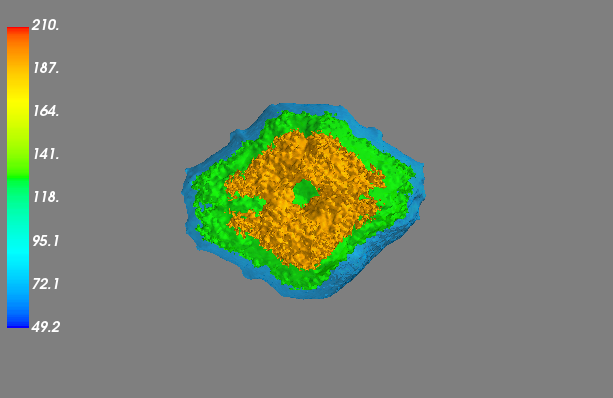

In [4]:
Image(filename='data/5a1a_projections_and_angles.png')

---

# Half-coverage Predicted Angles and Projections (Perfect)

In [10]:
INPUT_FILE = "5a1a_projections_and_angles_predicted"
OUTPUT_FILE = "5a1a_projections_and_angles_predicted"

## Reconstruction

In [11]:
reconstruction = reconstruct(INPUT_FILE, OUTPUT_FILE)

## Plot reconstruction result

In [12]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

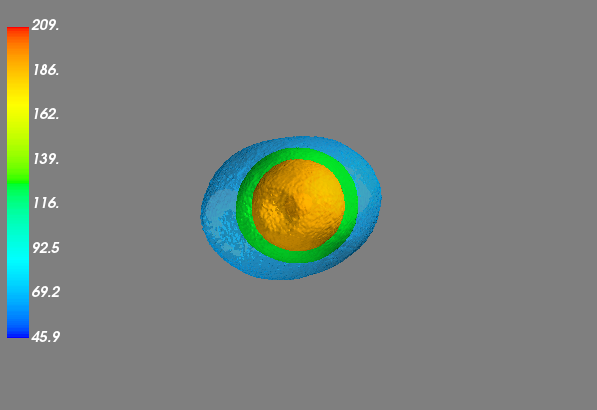

In [5]:
Image(filename='data/5a1a_projections_and_angles_predicted.png')

---

# Half-coverage Predicted Angles and Projections (Perfect Transposed)

In [12]:
INPUT_FILE = "5a1a_projections_and_angles_prefect_transposed"
OUTPUT_FILE = "5a1a_projections_and_angles_prefect_transposed"

## Reconstruction

In [14]:
reconstruction = reconstruct(INPUT_FILE, OUTPUT_FILE, save_mrc=False)

## Plot reconstruction result

In [15]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

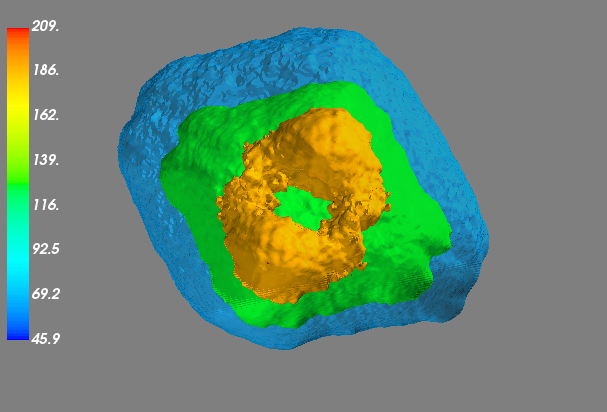

In [16]:
Image(filename='data/5a1a_projections_and_angles_prefect_transposed.png')

---

# Half-coverage Predicted Angles and Projections (Perfect Transposed Aligned)

In [4]:
INPUT_FILE = "5a1a_projections_and_angles_perfect_transposed_aligned"
OUTPUT_FILE = "5a1a_projections_and_angles_perfect_transposed_aligned"

## Reconstruction

In [5]:
reconstruction = reconstruct(INPUT_FILE, OUTPUT_FILE)

## Plot reconstruction result

In [6]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

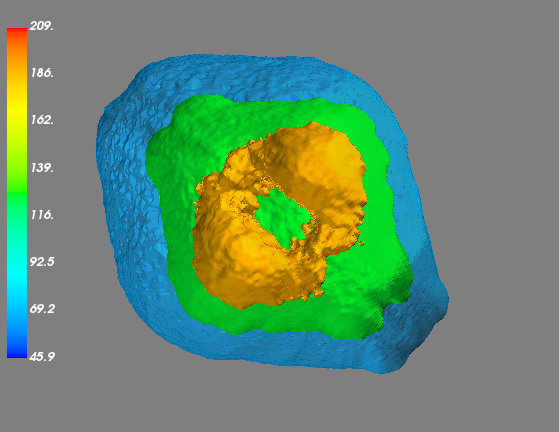

In [7]:
Image(filename='data/5a1a_projections_and_angles_perfect_transposed_aligned.png')

---

# Half-coverage Predicted Angles and Projections (Variance 0.8)

In [2]:
INPUT_FILE = "5a1a_projections_and_angles_predicted_var0.8"
OUTPUT_FILE = "5a1a_projections_and_angles_predicted_var0.8"

## Reconstruction

In [3]:
reconstruction = reconstruct(INPUT_FILE, OUTPUT_FILE)

## Plot reconstruction result

In [4]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

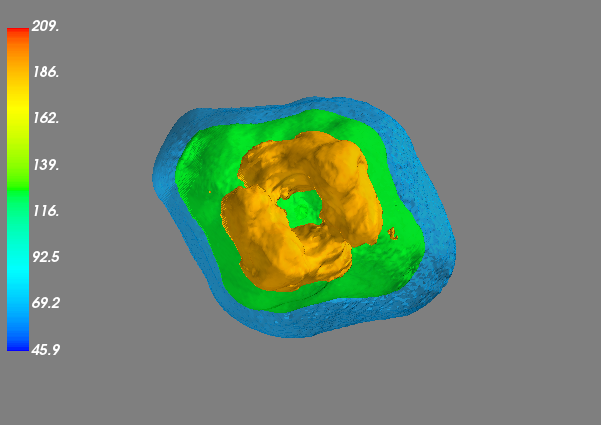

In [5]:
Image(filename='data/5a1a_projections_and_angles_predicted_var0.8.png')

---

# Half-coverage Predicted Angles and Projections (Rotation Matrix - not T)

In [2]:
INPUT_FILE = "5a1a_projections_and_angles_rotmattest"
OUTPUT_FILE = "5a1a_projections_and_angles_rotmattest"

## Reconstruction

In [3]:
reconstruction = reconstruct(INPUT_FILE, OUTPUT_FILE)

## Plot reconstruction result

In [4]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

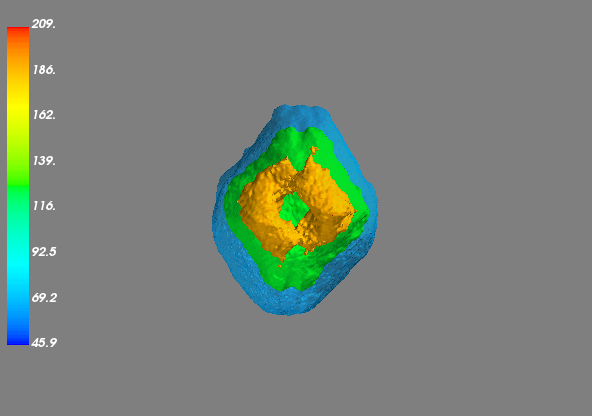

In [5]:
Image(filename='data/5a1a_projections_and_angles_rotmattest.png')

---

# Half-coverage Predicted Angles and Projections (Rotation Matrix - T)

In [2]:
INPUT_FILE = "5a1a_projections_and_angles_rotmattest_T"
OUTPUT_FILE = "5a1a_projections_and_angles_rotmattest_T"

## Reconstruction

In [3]:
reconstruction = reconstruct(INPUT_FILE, OUTPUT_FILE)

## Plot reconstruction result

In [4]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

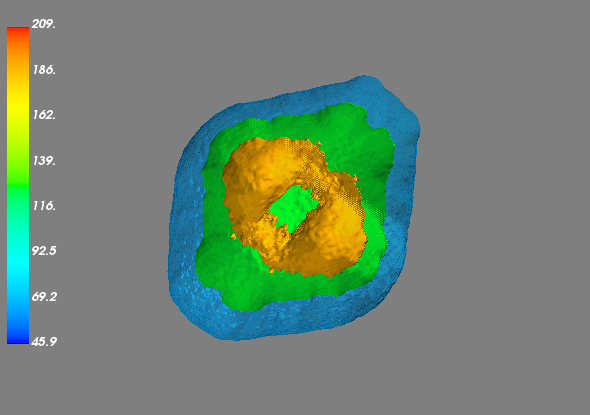

In [5]:
Image(filename='data/5a1a_projections_and_angles_rotmattest_T.png')

---

# Half-coverage Predicted Angles and Projections (Quaternions - T)

In [2]:
INPUT_FILE = "5a1a_projections_and_angles_quaterniontest_T"
OUTPUT_FILE = "5a1a_projections_and_angles_quaterniontest_T"

## Reconstruction

In [3]:
reconstruction = reconstruct(INPUT_FILE, OUTPUT_FILE)

## Plot reconstruction result

In [4]:
mlab.contour3d(reconstruction, transparent=True)
mlab.colorbar(orientation='vertical')
# mlab.savefig("data/5a1a_projections_and_angles.tiff")
mlab.show()

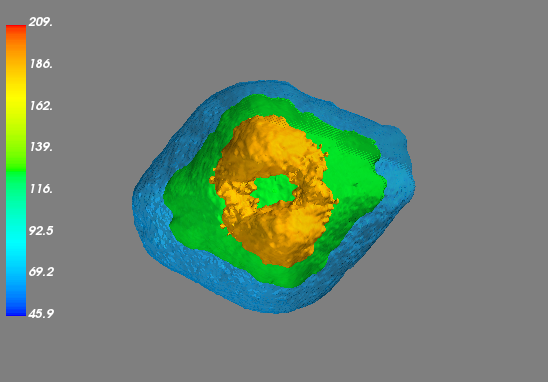

In [5]:
Image(filename='data/5a1a_projections_and_angles_quaterniontest_T.png')